In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
#import pixiedust
from gym.envs.registration import register
from qiskit.aqua.components.optimizers import ADAM
from qiskit import *
from datetime import datetime

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196, changing this seems have no influence
)

In [4]:
env = gym.make("FrozenLakeNotSlippery-v0")

In [5]:
def get_numStates(env):
    if type(env.observation_space) != gym.spaces.tuple.Tuple:
        return env.observation_space.n
    dim_list = []
    for sp in env.observation_space:
        dim_list.append(sp.n)
    dim_list = np.array(dim_list)
    return dim_list.prod()

In [6]:
def get_Statehash(env,state):
    if type(env.observation_space) != gym.spaces.tuple.Tuple:
        return state
    dim_list = []
    for sp in env.observation_space:
        dim_list.append(sp.n)
    dim_list = np.array(dim_list)
    h = 0
    for i in range(len(dim_list)-1):
        h += state[i]*dim_list[i+1:].prod()
    h += state[-1]
    return h
    

In [7]:
def QLearning(iterations,alpha, gamma, epsilon ,env):
    returnlist = []
    num_actions = env.action_space.n
    num_states = get_numStates(env)
    Q = np.zeros((num_states,num_actions))
    for it in range(iterations):
        state = env.reset()
        R = 0

        done = False
        while not done:
            state_h = get_Statehash(env,state)
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                candidates = np.where(Q[state_h] == np.max(Q[state_h]))[0]
                action = np.random.choice(candidates)
            statep, reward, done, info = env.step(action)
            if reward == 0:
                if done:
                    reward = -0.2
                else:
                    reward = -0.01
            else:
                reward = 1.0
            R *= gamma
            R += reward
            statep_h = get_Statehash(env,statep)
            Q[state_h,action] += alpha*(reward + gamma*Q[statep_h].max() -Q[state_h,action])
            state = statep
            
        returnlist.append(R)
        if it%10000 == 0:
            print('Iteration %d, Reward: %d'%(it,R))
            
    return returnlist, Q
        
        
        



In [ ]:
rl, Q = QLearning(100000,1e-3,0.99,0.25,env)  

In [ ]:
#     backend_sim = Aer.get_backend('qasm_simulator')

#     result = execute(qc, backend_sim, shots = shots).result()

#     counts = result.get_counts()
#     expect = np.zeros(nqbits)
#     for c in counts :
#         for n in range(nqbits):
#             expect[n] += int(c[n])*counts[c]/shots
#     #print(counts)
#     return np.array(expect)

In [7]:
def get_Qvalues(s_list,theta):
    shots = 1000
    nqbits = 4
    num_rep = 1
    qc_list = []
    for s in s_list:
        q = QuantumRegister(nqbits)
        c = ClassicalRegister(nqbits)
        qc = QuantumCircuit(q,c)

        d = np.binary_repr(int(s),nqbits)
        for j,i in enumerate(d):
            if i == '1':
                qc.x(q[j])

        count = 0

        for rep in range(num_rep):
            for i in range(1, nqbits):
                qc.cx(q[i-1], q[i])

            for i in range(nqbits):
                qc.u3(theta[count], theta[count + 1], theta[count + 2], q[i])
                count = count + 3

        #qc.measure(q,c)
        
        qc_list.append(qc)


    
    backend_sim = Aer.get_backend('statevector_simulator')
    qobj = assemble(qc_list,backend_sim)
    #result_list = execute(qc_list, backend_sim, optimization_level = 0).result()
    job = backend_sim.run(qobj)
    result_list = job.result()
    expect_list = []
    for result in result_list.results:
        proba = abs(np.array(result.data.statevector))**2


        expect = np.zeros(nqbits)

        for c in range(len(proba)):
            cbin = np.binary_repr(int(c),nqbits)

            for n in range(nqbits) : 
                if cbin[n] == '1':
                    expect[n] += proba[c]
                    
        expect_list.append(np.flip(expect))
                
    #print(counts)
    return expect_list

In [8]:
def loss(theta, t):
    su = 0
    Qs = get_Qvalues(t[:,1],theta)
    
    for i in range(len(t)):
        su += (t[i][0] - Qs[i][int(t[i][2])])**2
    return su

In [9]:
def DQN(iterations,alpha, gamma, epsilon ,env,N,batchsize):
    nqbits = 4
    D = []
    while len(D) < N:
        s = env.reset()
        done = False
        while not done:
            a = env.action_space.sample()
            s1, r, done,_ = env.step(a)
            if r == 0:
                if done:
                    r = -0.2
                else:
                    r = -0.01
            else:
                r = 1.0
            D.append((s,a,r,s1,done))
            s = s1
            if len(D) == N:
                break
    total_rewards = []
    theta = np.array([2*np.pi*np.random.random(3),2*np.pi*np.random.random(3),2*np.pi*np.random.random(3),2*np.pi*np.random.random(3)]).flatten()
    for it in range(iterations):
        s = env.reset()
        done = False
        total_reward = 0
        while not done:
            #env.render()
            if np.random.random() < epsilon*(0.99**it):
                a = env.action_space.sample()
            else:
                a = np.argmax(get_Qvalues([s],theta)[0])
            s1,r,done,_ = env.step(a)
            if r == 0:
                if done:
                    r = -0.2
                else:
                    r = -0.01
            else:
                r = 1.0
            #print(r)
            total_reward += r
            D.pop(0)
            D.append((s,a,r,s1,done))
        mB_ind = np.random.choice(range(N),size = batchsize,replace = False)
        mB = np.array(D)[mB_ind]
        #update Q on mB
        t = []
        for j in range(batchsize):
            if mB[j][-1]:
                y_j = mB[j][2]
            else:
                y_j = mB[j][2] + gamma*(2*max(get_Qvalues([mB[j][3]],theta)[0])-1)
            y_j /= 2
            y_j += 0.5
            t.append([y_j,mB[j][0],mB[j][1]])

        t = np.array(t)

        adam = ADAM(maxiter = 10, lr = alpha)
        start = datetime.now()
        print(theta)
        theta,_,_ = adam.optimize(3*nqbits,lambda x: loss(x,t), initial_point = theta)
        print(datetime.now()-start)
        if it %1 == 0:
            print('Iteration : ', it, 'Total reward: ', total_reward)
        total_rewards.append(total_reward)
        
    return total_rewards

In [51]:
for it in range(50):
    print(0.9*(0.95**it))

0.9
0.855
0.81225
0.7716374999999999
0.7330556249999999
0.6964028437499998
0.6615827015624999
0.6285035664843748
0.597078388160156
0.5672244687521482
0.5388632453145408
0.5119200830488138
0.486324078896373
0.4620078749515543
0.4389074812039766
0.41696210714377774
0.39611400178658884
0.3763083016972594
0.35749288661239637
0.33961824228177656
0.3226373301676877
0.30650546365930337
0.29118019047633814
0.27662118095252125
0.26279012190489515
0.2496506158096504
0.23716808501916783
0.22530968076820942
0.21404419672979894
0.20334198689330898
0.19317488754864354
0.18351614317121134
0.17434033601265078
0.16562331921201826
0.15734215325141732
0.14947504558884644
0.14200129330940411
0.13490122864393392
0.1281561672117372
0.12174835885115033
0.11566094090859282
0.10987789386316317
0.104383999170005
0.09916479921150476
0.09420655925092951
0.08949623128838302
0.08502141972396388
0.08077034873776569
0.07673183130087738
0.07289523973583352


In [10]:
total_rewards = DQN(100,1e-1,0.99,0.9,env,100,10)

[0.73382753 0.79757302 5.2339608  2.42235478 2.96652883 2.48884058
 1.91673216 3.6061689  3.38333838 3.43574185 5.26956836 5.95155978]
0:00:04.128194
Iteration :  0 Total reward:  -0.32999999999999996
[1.64822148 0.26801752 4.82763436 1.45398025 3.24276794 2.59214689
 1.99401989 3.55141027 3.7456713  3.51173815 5.19115819 6.43248644]
0:00:04.149396
Iteration :  1 Total reward:  -0.32
[1.73288994 0.41904597 5.41863689 1.40450943 3.08549373 3.02804377
 1.53458682 3.5608932  4.02176206 4.51850665 5.56325589 6.64851843]
0:00:04.191986
Iteration :  2 Total reward:  -0.21000000000000002
[1.78096661 0.61861777 5.22062657 1.77084372 3.68964352 3.51124205
 1.71887282 3.15025581 3.96441381 4.82536856 5.41572358 6.86340739]
0:00:04.194157
Iteration :  3 Total reward:  -0.38
[1.70386966 0.47589427 4.93911704 1.36447508 3.25718974 2.93980857
 1.62073481 2.95191239 3.59502817 4.75539108 5.46002474 7.06448982]
0:00:04.121441
Iteration :  4 Total reward:  -0.21000000000000002
[1.65198411 0.61919822 4.

In [13]:
print(total_rewards)

[-0.32999999999999996, -0.32, -0.21000000000000002, -0.38, -0.21000000000000002, -0.21000000000000002, -0.26, -0.38, -0.29000000000000004, -0.27, -0.32, -0.23, -0.25, -0.27, -0.23, -0.21000000000000002, -0.22, -0.43000000000000005, -0.21000000000000002, -0.37, -0.21000000000000002, -0.23, -0.21000000000000002, -0.21000000000000002, -0.22, -0.42000000000000004, -0.31, -0.28, -0.25, -0.31, -0.23, -0.4700000000000001, -0.32, -0.21000000000000002, -0.28, -0.3, -0.26, -0.29000000000000004, -0.24000000000000002, -0.33999999999999997, -0.22, -0.37, -0.22, -0.28, -0.25, -0.8400000000000003, -0.21000000000000002, -0.31, -0.23, -0.25, -0.32999999999999996, -0.21000000000000002, -0.21000000000000002, -0.36, -0.33999999999999997, -0.22, -0.22, -0.41000000000000003, -0.23, -0.25, -0.5200000000000001, -0.32, -0.21000000000000002, -0.26, -0.22, -0.4800000000000001, -0.28, -0.42000000000000004, -0.5500000000000002, -0.33999999999999997, -0.42000000000000004, -0.22, -0.32, -0.5200000000000001, -0.27, -

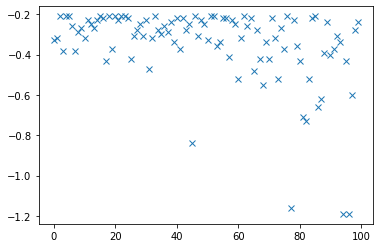

In [14]:
plt.plot(total_rewards,'x')
plt.show()

In [36]:
env.reset()

0

0 - left
1 - down
2 - right
3 - up

0|1|2|3
4|5|6|7
8|9|10|11
12|13|14|15

In [41]:
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [42]:
env.step(1)


(4, 0.0, False, {'prob': 1.0})

In [46]:
0.99*0.92 - 0.01

0.9008